<a href="https://colab.research.google.com/github/Sarya-Mariam/AI_SpillGuard_OSD-Sarya-Mariam-Jacob/blob/main/Oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
from glob import glob
from pathlib import Path


import numpy as np
import cv2
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from sklearn.model_selection import train_test_split


import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATASET_DIR = '/content/drive/MyDrive/oil_spill_dataset'
IMAGES_DIR = os.path.join(DATASET_DIR, 'train', 'images')
MASKS_DIR = os.path.join(DATASET_DIR, 'masks')


IMG_SIZE = 256
BATCH_SIZE = 8
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
!ls "$DATASET_DIR/train/images" | head -20

Oil (1000).jpg
Oil (1001).jpg
Oil (1002).jpg
Oil (1003).jpg
Oil (1004).jpg
Oil (1005).jpg
Oil (1006).jpg
Oil (1009).jpg
Oil (100).jpg
Oil (1010).jpg
Oil (1011).jpg
Oil (1012).jpg
Oil (1013).jpg
Oil (1015).jpg
Oil (1016).jpg
Oil (1017).jpg
Oil (1018).jpg
Oil (101).jpg
Oil (1020).jpg
Oil (1021).jpg


In [4]:
#  Utility functions
def read_image(path, size=IMG_SIZE):
 img = cv2.imread(path, cv2.IMREAD_COLOR)
 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
 img = img.astype('float32') / 255.0
 return img



def read_mask(path, size=IMG_SIZE):
# Read mask, convert to grayscale, then binary (0/1)
 m = cv2.imread(path, cv2.IMREAD_COLOR)
 if m is None:
  raise FileNotFoundError(path)
# If mask is RGB with colored annotations, convert to grayscale first
 gray = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
# Threshold to binary: any non-zero pixel -> 1
 binary = cv2.threshold(gray, 10, 1, cv2.THRESH_BINARY)
 binary = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)
 binary = binary.astype('float32')
# Expand dims for channel
 binary = np.expand_dims(binary, axis=-1)
 return binary




def visualize_pipeline(img_path, mask_path, augmentor=None, size=IMG_SIZE):
 img = read_image(img_path, size)
 mask = read_mask(mask_path, size)


# Apply augmentation if provided
 if augmentor is not None:
  augmented = augmentor(image=(img * 255).astype('uint8'), mask=(mask[:,:,0] * 255).astype('uint8'))
  aug_img = augmented['image'].astype('float32') / 255.0
  aug_mask = augmented['mask'].astype('float32') / 255.0
  aug_mask = np.expand_dims((aug_mask > 0.5).astype('float32'), -1)
 else:
  aug_img, aug_mask = None, None


 fig, axs = plt.subplots(1, 4 if augmentor is not None else 3, figsize=(16, 6))
 axs[0].imshow(img)
 axs[0].set_title('Original Image')
 axs[0].axis('off')


 axs[1].imshow(mask[:,:,0], cmap='gray')
 axs[1].set_title('Original Mask (binary)')
 axs[1].axis('off')


 axs[2].imshow(img)
 axs[2].imshow(mask[:,:,0], cmap='jet', alpha=0.4)
 axs[2].set_title('Overlay (preprocessed)')
 axs[2].axis('off')


 if augmentor is not None:
  axs[3].imshow(aug_img)
  axs[3].imshow(aug_mask[:,:,0], cmap='jet', alpha=0.4)
  axs[3].set_title('Augmented Image + Mask')
  axs[3].axis('off')


 plt.tight_layout()
 plt.show()

In [ ]:
!find /content/drive/MyDrive/oil_spill_dataset -type f | grep -i mask | head -20


/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1014).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1074).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1008).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1045).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1122).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1093).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1072).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1108).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1084).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1058).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1033).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1128).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1062).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1086).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1100).png
/content/d

To check the files in your masks directory, run the following code. This will list all files and folders within the `MASKS_DIR`.

In [5]:
#  Gather file lists based on dataset split structure
import glob
from pathlib import Path

BASE_DIR = "/content/drive/MyDrive/oil_spill_dataset"  # change if needed

def load_split(split):
    img_dir = os.path.join(BASE_DIR, split, "images")
    mask_dir = os.path.join(BASE_DIR, split, "masks")

    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"Image directory not found: {img_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    image_paths = sorted(glob.glob(os.path.join(img_dir, "*")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))

    if len(image_paths) != len(mask_paths):
        print(f"⚠️ Warning: {split} images={len(image_paths)}, masks={len(mask_paths)} (count mismatch)")

    # Show first few pairs
    for i in range(min(3, len(image_paths))):
        print(f"{split} sample -> Image: {Path(image_paths[i]).name}, Mask: {Path(mask_paths[i]).name}")

    return image_paths, mask_paths

# Load splits
train_imgs, train_masks = load_split("train")
val_imgs, val_masks     = load_split("val")
test_imgs, test_masks   = load_split("test") if os.path.exists(os.path.join(BASE_DIR, "test")) else ([], [])

print("Train:", len(train_imgs), "Val:", len(val_imgs), "Test:", len(test_imgs))


train sample -> Image: Oil (1).jpg, Mask: Oil (1).png
train sample -> Image: Oil (10).jpg, Mask: Oil (10).png
train sample -> Image: Oil (100).jpg, Mask: Oil (100).png
val sample -> Image: Oil (1008).jpg, Mask: Oil (1008).png
val sample -> Image: Oil (1014).jpg, Mask: Oil (1014).png
val sample -> Image: Oil (1033).jpg, Mask: Oil (1033).png
test sample -> Image: Oil (1007).jpg, Mask: Oil (1007).png
test sample -> Image: Oil (1019).jpg, Mask: Oil (1019).png
test sample -> Image: Oil (1024).jpg, Mask: Oil (1024).png
Train: 811 Val: 203 Test: 254


In [6]:
def read_mask(path, size=256):
    # Read mask, convert to grayscale
    m = cv2.imread(path, cv2.IMREAD_COLOR)
    if m is None:
        raise FileNotFoundError(path)
    gray = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)

    # Threshold to binary: any non-zero pixel -> 1
    _, binary = cv2.threshold(gray, 10, 1, cv2.THRESH_BINARY)

    # Resize to target size
    binary = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)

    # Expand dims for channel
    binary = binary.astype('float32')
    binary = np.expand_dims(binary, axis=-1)
    return binary


In [7]:
# Augmentation setup (albumentations)
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
], additional_targets={'mask': 'mask'})

# For validation/test: only resize/normalize
valid_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [8]:
#  tf.data Dataset pipeline

def generator(image_paths, mask_paths, augmentor=None, batch_size=BATCH_SIZE, shuffle=True):
    n = len(image_paths)
    idxs = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for i in range(0, n, batch_size):
            batch_idxs = idxs[i:i+batch_size]
            imgs = []
            msks = []
            for j in batch_idxs:
                img = read_image(image_paths[j], IMG_SIZE)
                m = read_mask(mask_paths[j], IMG_SIZE)
                if augmentor is not None:
                    aug = augmentor(image=(img*255).astype('uint8'), mask=(m[:,:,0]*255).astype('uint8'))
                    img = aug['image'].astype('float32') / 255.0
                    mask = aug['mask'].astype('float32') / 255.0
                    # ensure binary mask
                    mask = np.expand_dims((mask > 0.5).astype('float32'), -1)
                else:
                    mask = m
                imgs.append(img)
                msks.append(mask)
            imgs = np.stack(imgs, axis=0)
            msks = np.stack(msks, axis=0)
            yield imgs, msks

# Wrap as tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: generator(train_imgs, train_masks, augmentor=train_aug, batch_size=BATCH_SIZE, shuffle=True),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: generator(val_imgs, val_masks, augmentor=None, batch_size=BATCH_SIZE, shuffle=False),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
)

# === Test dataset generator ===
import math
total_test_images = len(test_imgs)
batch_size = BATCH_SIZE
total_test_steps = math.ceil(total_test_images / batch_size)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator(test_imgs, test_masks, augmentor=None, batch_size=BATCH_SIZE, shuffle=False),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
).apply(tf.data.experimental.assert_cardinality(total_test_steps)) # Explicitly set cardinality


# Prefetching
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [9]:
#  U-Net model definition

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPool2D((2,2))(c)
    return c, p


def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    b = conv_block(p4, 512)

    d4 = decoder_block(b, c4, 256)
    d3 = decoder_block(d4, c3, 128)
    d2 = decoder_block(d3, c2, 64)
    d1 = decoder_block(d2, c1, 32)

    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d1)

    model = keras.Model(inputs, outputs)
    return model

In [10]:
# Losses and metrics

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def bce_dice_loss(y_true, y_pred):
    bce = keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return bce + dice_loss

In [11]:
# Compile model
model = build_unet()
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.MeanMetricWrapper(iou_coef, name='iou'),
                       tf.keras.metrics.MeanMetricWrapper(dice_coef, name='dice')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[

 Total params: 7,858,433 (29.98 MB)

 Trainable params: 7,852,545 (29.96 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint('unet_oilspill_best.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
]


In [ ]:
# Training
EPOCHS = 10
STEPS_PER_EPOCH = max(1, len(train_imgs) // BATCH_SIZE)
VAL_STEPS = max(1, len(val_imgs) // BATCH_SIZE)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS,
    callbacks=callbacks
)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7420 - dice: 0.7224 - iou: 0.5666 - loss: 0.8914 - precision: 0.9763 - recall: 0.7380 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2279s 23s/step - accuracy: 0.7429 - dice: 0.7227 - iou: 0.5670 - loss: 0.8904 - precision: 0.9763 - recall: 0.7390 - val_accuracy: 0.9566 - val_dice: 0.7899 - val_iou: 0.6529 - val_loss: 0.6360 - val_precision: 0.9595 - val_recall: 0.9968 - learning_rate: 1.0000e-04
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9201 - dice: 0.8001 - iou: 0.6677 - loss: 0.6312 - precision: 0.9682 - recall: 0.9438 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2245s 22s/step - accuracy: 0.9203 - dice: 0.8002 - iou: 0.6678 - loss: 0.6308 - precision: 0.9682 - recall: 0.9439 - val_accuracy: 0.9572 - val_dice: 0.8469 - val_iou: 0.7346 - val_loss: 0.4733 - val_precision: 0.9602 - val_recall: 0.9967 - learning_rate: 1.0000e-04
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9425 - dice: 0.8246 - iou: 0.7022 - loss: 0.5596 - precision: 0.9725 - recall: 0.9649 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2217s 22s/step - accuracy: 0.9425 - dice: 0.8246 - iou: 0.7022 - loss: 0.5595 - precision: 0.9725 - recall: 0.9649 - val_accuracy: 0.9586 - val_dice: 0.8933 - val_iou: 0.8075 - val_loss: 0.3455 - val_precision: 0.9623 - val_recall: 0.9959 - learning_rate: 1.0000e-04
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9468 - dice: 0.8431 - iou: 0.7295 - loss: 0.5192 - precision: 0.9711 - recall: 0.9713 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2229s 22s/step - accuracy: 0.9469 - dice: 0.8431 - iou: 0.7295 - loss: 0.5191 - precision: 0.9711 - recall: 0.9713 - val_accuracy: 0.9621 - val_dice: 0.9030 - val_iou: 0.8235 - val_loss: 0.3182 - val_precision: 0.9670 - val_recall: 0.9944 - learning_rate: 1.0000e-04
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9582 - dice: 0.8630 - iou: 0.7599 - loss: 0.4409 - precision: 0.9758 - recall: 0.9791 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2236s 22s/step - accuracy: 0.9582 - dice: 0.8630 - iou: 0.7599 - loss: 0.4409 - precision: 0.9758 - recall: 0.9791 - val_accuracy: 0.9639 - val_dice: 0.9065 - val_iou: 0.8293 - val_loss: 0.3090 - val_precision: 0.9695 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2213s 22s/step - accuracy: 0.9571 - dice: 0.8729 - iou: 0.7752 - loss: 0.4112 - precision: 0.9707 - recall: 0.9830 - val_accuracy: 0.9634 - val_dice: 0.9096 - val_iou: 0.8344 - val_loss: 0.3095 - val_precision: 0.9716 - val_recall: 0.9907 - learning_rate: 1.0000e-04
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9607 - dice: 0.8854 - iou: 0.7952 - loss: 0.3778 - precision: 0.9731 - recall: 0.9847 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2220s 22s/step - accuracy: 0.9607 - dice: 0.8854 - iou: 0.7952 - loss: 0.3777 - precision: 0.9731 - recall: 0.9847 - val_accuracy: 0.9661 - val_dice: 0.9228 - val_iou: 0.8569 - val_loss: 0.2688 - val_precision: 0.9710 - val_recall: 0.9943 - learning_rate: 1.0000e-04
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9645 - dice: 0.8980 - iou: 0.8156 - loss: 0.3348 - precision: 0.9745 - recall: 0.9873 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2233s 22s/step - accuracy: 0.9644 - dice: 0.8980 - iou: 0.8156 - loss: 0.3349 - precision: 0.9745 - recall: 0.9873 - val_accuracy: 0.9659 - val_dice: 0.9243 - val_iou: 0.8597 - val_loss: 0.2664 - val_precision: 0.9719 - val_recall: 0.9932 - learning_rate: 1.0000e-04
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9612 - dice: 0.9041 - iou: 0.8257 - loss: 0.3248 - precision: 0.9711 - recall: 0.9873 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2252s 22s/step - accuracy: 0.9612 - dice: 0.9041 - iou: 0.8256 - loss: 0.3248 - precision: 0.9711 - recall: 0.9873 - val_accuracy: 0.9654 - val_dice: 0.9318 - val_iou: 0.8727 - val_loss: 0.2457 - val_precision: 0.9695 - val_recall: 0.9952 - learning_rate: 1.0000e-04
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2225s 22s/step - accuracy: 0.9595 - dice: 0.9109 - iou: 0.8369 - loss: 0.3041 - precision: 0.9663 - recall: 0.9905 - val_accuracy: 0.9657 - val_dice: 0.9281 - val_iou: 0.8661 - val_loss: 0.2563 - val_precision: 0.9710 - val_recall: 0.9939 - learning_rate: 1.0000e-04


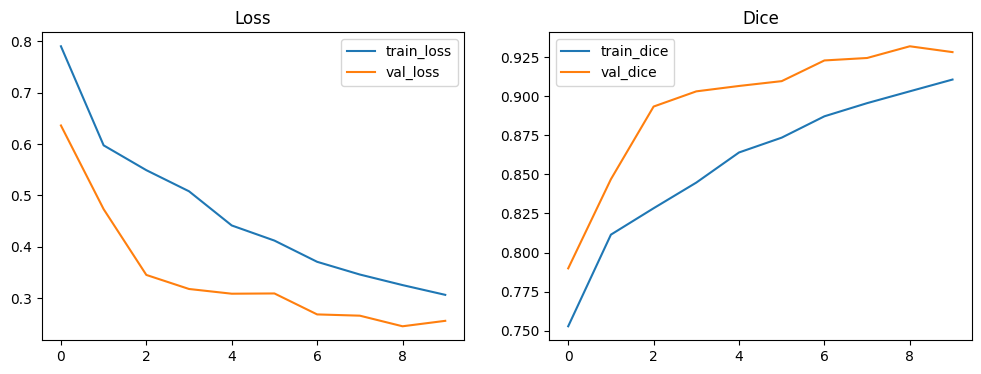

In [ ]:
# Training plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['dice'], label='train_dice')
plt.plot(history.history['val_dice'], label='val_dice')
plt.legend(); plt.title('Dice')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


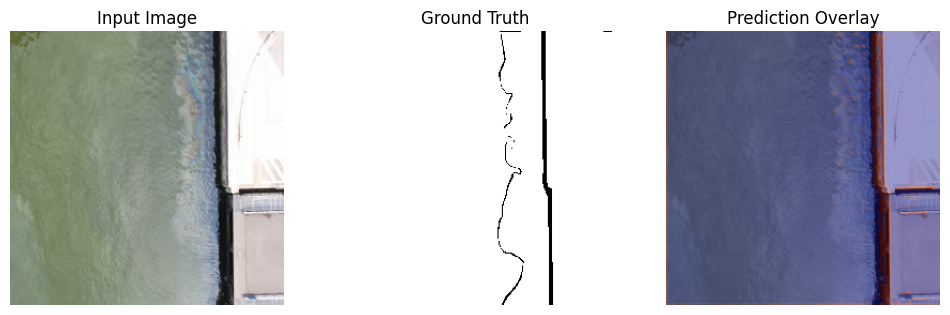

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


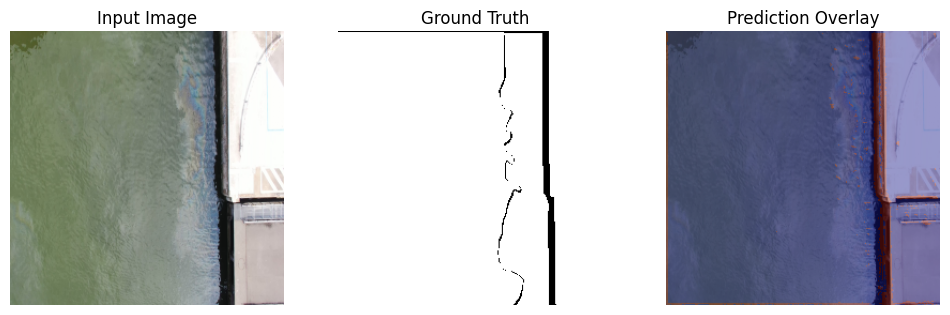

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


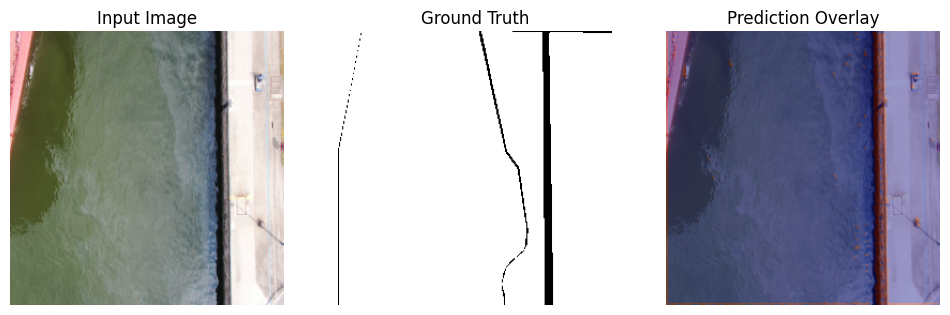

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


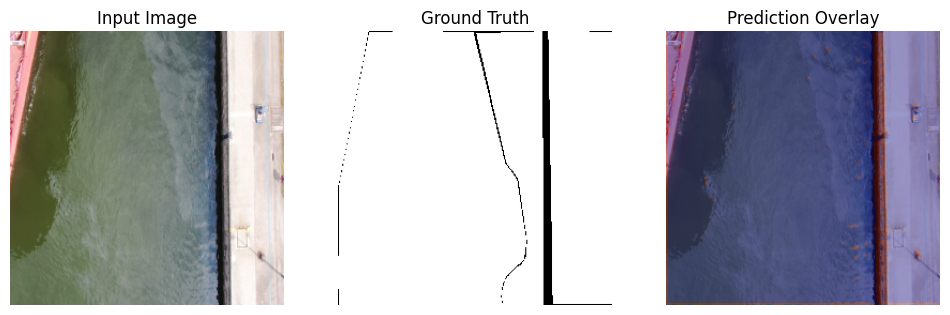

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


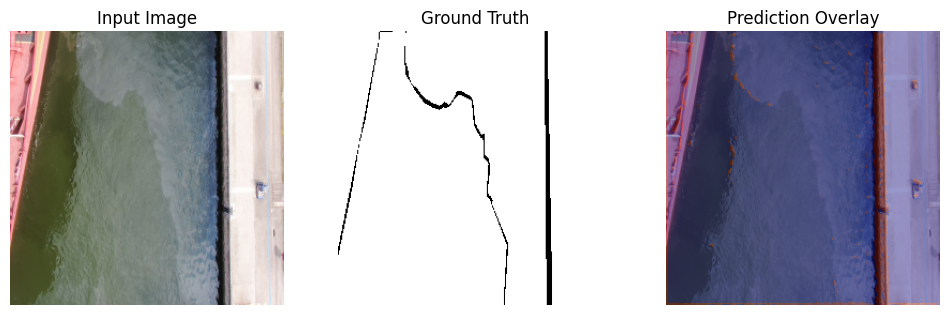

In [ ]:
# Visualize predictions on validation set

def predict_and_plot(sample_img_path, sample_mask_path):
    img = read_image(sample_img_path)
    mask = read_mask(sample_mask_path)
    inp = np.expand_dims(img, 0)
    pred = model.predict(inp)[0]
    pred_bin = (pred[:,:,0] > 0.5).astype('float32')

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(img); axs[0].set_title('Input Image'); axs[0].axis('off')
    axs[1].imshow(mask[:,:,0], cmap='gray'); axs[1].set_title('Ground Truth'); axs[1].axis('off')
    axs[2].imshow(img); axs[2].imshow(pred_bin, cmap='jet', alpha=0.4); axs[2].set_title('Prediction Overlay'); axs[2].axis('off')
    plt.show()

# pick a few val samples
for i in range(min(5, len(val_imgs))):
    predict_and_plot(val_imgs[i], val_masks[i])

In [ ]:
# Save model and notes
model.save('unet_oilspill_final.h5')
print('Model saved to unet_oilspill_final.h5')


Model saved to unet_oilspill_final.h5


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint("unet_best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
earlystop  = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reducelr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7)

callbacks = [checkpoint, earlystop, reducelr]

# Training
EPOCHS = 20
STEPS_PER_EPOCH = max(1, len(train_imgs) // BATCH_SIZE)
VAL_STEPS = max(1, len(val_imgs) // BATCH_SIZE)

history = model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8438 - dice: 0.7685 - iou: 0.6253 - loss: 0.7709 - precision: 0.9751 - recall: 0.8530 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2397s 24s/step - accuracy: 0.8444 - dice: 0.7688 - iou: 0.6257 - loss: 0.7699 - precision: 0.9751 - recall: 0.8537 - val_accuracy: 0.9591 - val_dice: 0.8052 - val_iou: 0.6741 - val_loss: 0.5929 - val_precision: 0.9591 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9455 - dice: 0.8371 - iou: 0.7207 - loss: 0.5252 - precision: 0.9703 - recall: 0.9706 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2417s 24s/step - accuracy: 0.9455 - dice: 0.8372 - iou: 0.7207 - loss: 0.5250 - precision: 0.9702 - recall: 0.9706 - val_accuracy: 0.9591 - val_dice: 0.8713 - val_iou: 0.7722 - val_loss: 0.4078 - val_precision: 0.9591 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9553 - dice: 0.8593 - iou: 0.7541 - loss: 0.4662 - precision: 0.9734 - recall: 0.9783 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2370s 23s/step - accuracy: 0.9553 - dice: 0.8593 - iou: 0.7541 - loss: 0.4661 - precision: 0.9733 - recall: 0.9783 - val_accuracy: 0.9591 - val_dice: 0.8893 - val_iou: 0.8010 - val_loss: 0.3579 - val_precision: 0.9591 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9550 - dice: 0.8695 - iou: 0.7700 - loss: 0.4217 - precision: 0.9690 - recall: 0.9825 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2365s 23s/step - accuracy: 0.9550 - dice: 0.8695 - iou: 0.7701 - loss: 0.4216 - precision: 0.9689 - recall: 0.9825 - val_accuracy: 0.9607 - val_dice: 0.8964 - val_iou: 0.8125 - val_loss: 0.3350 - val_precision: 0.9624 - val_recall: 0.9980 - learning_rate: 1.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9573 - dice: 0.8773 - iou: 0.7824 - loss: 0.3966 - precision: 0.9690 - recall: 0.9853 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2371s 23s/step - accuracy: 0.9573 - dice: 0.8773 - iou: 0.7824 - loss: 0.3966 - precision: 0.9690 - recall: 0.9853 - val_accuracy: 0.9626 - val_dice: 0.9073 - val_iou: 0.8306 - val_loss: 0.3095 - val_precision: 0.9688 - val_recall: 0.9930 - learning_rate: 1.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9621 - dice: 0.8919 - iou: 0.8060 - loss: 0.3586 - precision: 0.9718 - recall: 0.9877 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2380s 24s/step - accuracy: 0.9621 - dice: 0.8919 - iou: 0.8060 - loss: 0.3586 - precision: 0.9718 - recall: 0.9877 - val_accuracy: 0.9641 - val_dice: 0.9210 - val_iou: 0.8539 - val_loss: 0.2709 - val_precision: 0.9678 - val_recall: 0.9957 - learning_rate: 1.0000e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9588 - dice: 0.9025 - iou: 0.8229 - loss: 0.3283 - precision: 0.9660 - recall: 0.9901 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2377s 24s/step - accuracy: 0.9588 - dice: 0.9025 - iou: 0.8229 - loss: 0.3284 - precision: 0.9660 - recall: 0.9901 - val_accuracy: 0.9657 - val_dice: 0.9229 - val_iou: 0.8571 - val_loss: 0.2637 - val_precision: 0.9689 - val_recall: 0.9962 - learning_rate: 1.0000e-04
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9605 - dice: 0.9102 - iou: 0.8359 - loss: 0.3117 - precision: 0.9677 - recall: 0.9902 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2421s 24s/step - accuracy: 0.9605 - dice: 0.9102 - iou: 0.8360 - loss: 0.3117 - precision: 0.9677 - recall: 0.9902 - val_accuracy: 0.9623 - val_dice: 0.9317 - val_iou: 0.8725 - val_loss: 0.2472 - val_precision: 0.9679 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9580 - dice: 0.9123 - iou: 0.8396 - loss: 0.3126 - precision: 0.9660 - recall: 0.9894 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2366s 23s/step - accuracy: 0.9580 - dice: 0.9123 - iou: 0.8397 - loss: 0.3124 - precision: 0.9660 - recall: 0.9894 - val_accuracy: 0.9650 - val_dice: 0.9362 - val_iou: 0.8804 - val_loss: 0.2279 - val_precision: 0.9681 - val_recall: 0.9964 - learning_rate: 1.0000e-04
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9608 - dice: 0.9211 - iou: 0.8546 - loss: 0.2760 - precision: 0.9669 - recall: 0.9914 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2369s 23s/step - accuracy: 0.9607 - dice: 0.9211 - iou: 0.8546 - loss: 0.2760 - precision: 0.9669 - recall: 0.9914 - val_accuracy: 0.9648 - val_dice: 0.9398 - val_iou: 0.8868 - val_loss: 0.2173 - val_precision: 0.9678 - val_recall: 0.9964 - learning_rate: 1.0000e-04
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9624 - dice: 0.9297 - iou: 0.8695 - loss: 0.2482 - precision: 0.9672 - recall: 0.9928 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2422s 24s/step - accuracy: 0.9624 - dice: 0.9297 - iou: 0.8696 - loss: 0.2482 - precision: 0.9672 - recall: 0.9928 - val_accuracy: 0.9656 - val_dice: 0.9446 - val_iou: 0.8953 - val_loss: 0.2041 - val_precision: 0.9686 - val_recall: 0.9965 - learning_rate: 1.0000e-04
Epoch 12/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9632 - dice: 0.9356 - iou: 0.8798 - loss: 0.2359 - precision: 0.9681 - recall: 0.9927 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2422s 24s/step - accuracy: 0.9632 - dice: 0.9356 - iou: 0.8797 - loss: 0.2359 - precision: 0.9681 - recall: 0.9927 - val_accuracy: 0.9662 - val_dice: 0.9495 - val_iou: 0.9042 - val_loss: 0.1907 - val_precision: 0.9685 - val_recall: 0.9972 - learning_rate: 1.0000e-04
Epoch 13/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2420s 24s/step - accuracy: 0.9617 - dice: 0.9381 - iou: 0.8840 - loss: 0.2331 - precision: 0.9672 - recall: 0.9921 - val_accuracy: 0.9660 - val_dice: 0.9470 - val_iou: 0.8997 - val_loss: 0.2001 - val_precision: 0.9690 - val_recall: 0.9964 - learning_rate: 1.0000e-04
Epoch 14/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9621 - dice: 0.9452 - iou: 0.8967 - loss: 0.2083 - precision: 0.9649 - recall: 0.9947 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2423s 24s/step - accuracy: 0.9621 - dice: 0.9452 - iou: 0.8968 - loss: 0.2082 - precision: 0.9649 - recall: 0.9947 - val_accuracy: 0.9662 - val_dice: 0.9547 - val_iou: 0.9136 - val_loss: 0.1758 - val_precision: 0.9692 - val_recall: 0.9964 - learning_rate: 1.0000e-04
Epoch 15/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9589 - dice: 0.9406 - iou: 0.8885 - loss: 0.2376 - precision: 0.9646 - recall: 0.9918 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2360s 23s/step - accuracy: 0.9589 - dice: 0.9406 - iou: 0.8885 - loss: 0.2376 - precision: 0.9646 - recall: 0.9918 - val_accuracy: 0.9658 - val_dice: 0.9563 - val_iou: 0.9167 - val_loss: 0.1747 - val_precision: 0.9687 - val_recall: 0.9965 - learning_rate: 1.0000e-04
Epoch 16/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9644 - dice: 0.9502 - iou: 0.9057 - loss: 0.1924 - precision: 0.9680 - recall: 0.9942 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2363s 23s/step - accuracy: 0.9644 - dice: 0.9501 - iou: 0.9057 - loss: 0.1925 - precision: 0.9680 - recall: 0.9942 - val_accuracy: 0.9664 - val_dice: 0.9574 - val_iou: 0.9187 - val_loss: 0.1661 - val_precision: 0.9692 - val_recall: 0.9966 - learning_rate: 1.0000e-04
Epoch 17/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9675 - dice: 0.9509 - iou: 0.9067 - loss: 0.1846 - precision: 0.9720 - recall: 0.9937 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2360s 23s/step - accuracy: 0.9675 - dice: 0.9509 - iou: 0.9067 - loss: 0.1847 - precision: 0.9720 - recall: 0.9937 - val_accuracy: 0.9662 - val_dice: 0.9611 - val_iou: 0.9256 - val_loss: 0.1584 - val_precision: 0.9696 - val_recall: 0.9960 - learning_rate: 1.0000e-04
Epoch 18/20
 96/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 22s/step - accuracy: 0.9627 - dice: 0.9508 - iou: 0.9068 - loss: 0.1945 - precision: 0.9674 - recall: 0.9931

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


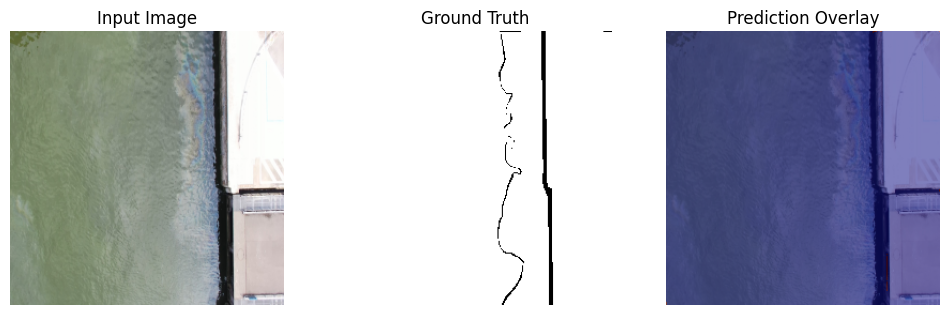

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


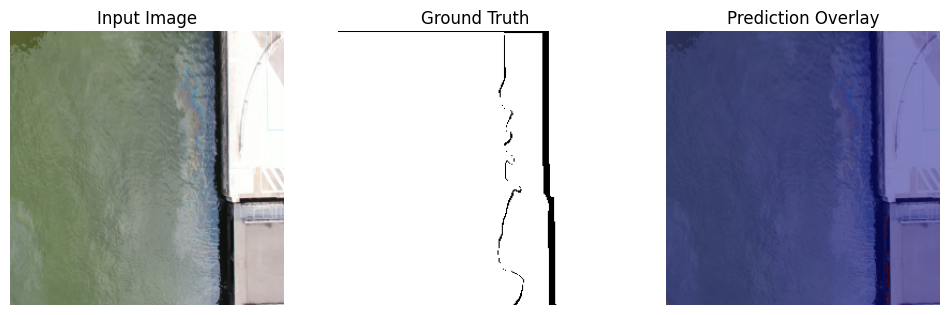

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


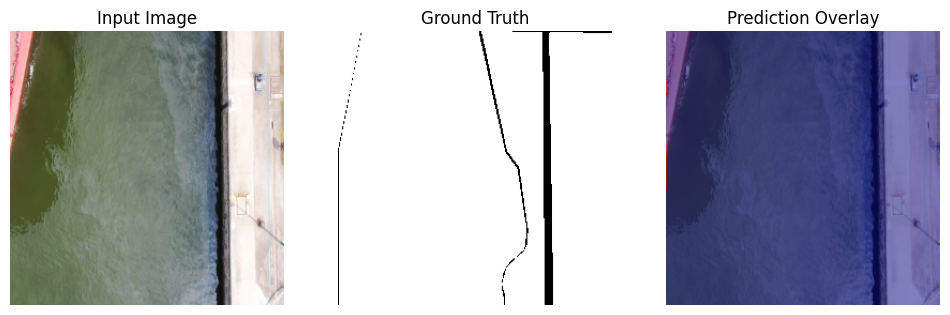

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


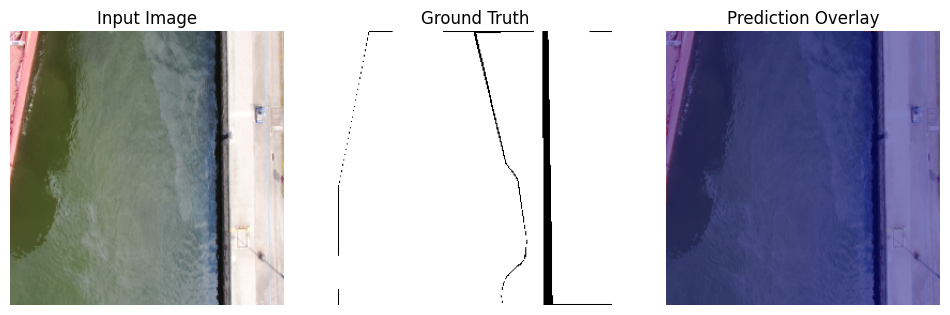

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


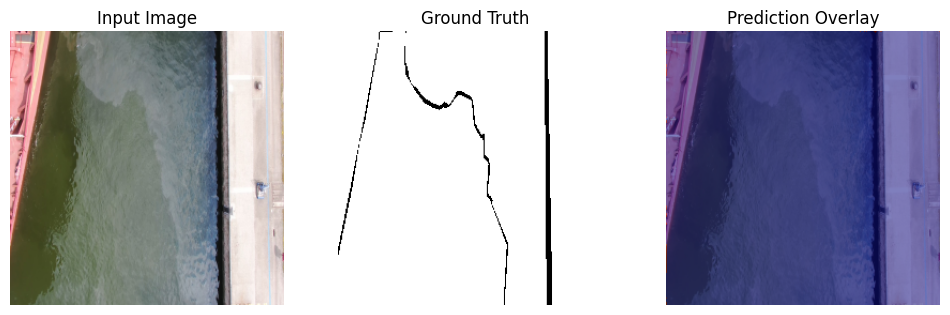

In [13]:
def show_predictions(image_paths, mask_paths, model, n=3):
    for i in range(n):
        img = read_image(image_paths[i])
        mask = read_mask(mask_paths[i])
        pred = model.predict(np.expand_dims(img, 0))[0]
        pred_bin = (pred[:,:,0] > 0.5).astype("float32")

        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(img); axs[0].set_title("Input Image"); axs[0].axis("off")
        axs[1].imshow(mask[:,:,0], cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
        axs[2].imshow(img); axs[2].imshow(pred_bin, cmap="jet", alpha=0.5); axs[2].set_title("Prediction Overlay"); axs[2].axis("off")
        plt.show()

# Example usage: show results from validation set
show_predictions(val_imgs, val_masks, model, n=5)

In [14]:
results = model.evaluate(test_ds)
print("Test set evaluation:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 263s 8s/step - accuracy: 0.0446 - dice: 0.6381 - iou: 0.4686 - loss: 1.0943 - precision: 0.6008 - recall: 5.3696e-04
Test set evaluation:
loss: 1.0946
compile_metrics: 0.0400


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

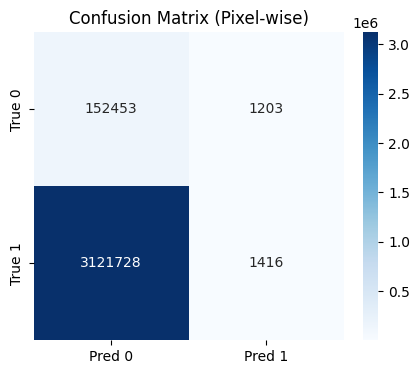

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_confusion_matrix_metrics(model, img_paths, mask_paths, threshold=0.5, n_samples=50):
    """
    Computes pixel-wise confusion matrix and metrics (Precision, Recall, F1, IoU).
    """
    y_true_all, y_pred_all = [], []

    # Collect predictions for a subset of test images
    for i in range(min(n_samples, len(img_paths))):
        img = read_image(img_paths[i])
        mask = read_mask(mask_paths[i])

        pred = model.predict(np.expand_dims(img, 0))[0]
        pred_bin = (pred[:,:,0] > threshold).astype("int").flatten()
        mask_bin = mask[:,:,0].astype("int").flatten()

        y_true_all.extend(mask_bin)
        y_pred_all.extend(pred_bin)

    # Confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    TN, FP, FN, TP = cm.ravel()

    # Metrics
    precision = TP / (TP + FP + 1e-7)
    recall    = TP / (TP + FN + 1e-7)
    f1_score  = 2 * precision * recall / (precision + recall + 1e-7)
    iou       = TP / (TP + FP + FN + 1e-7)

    metrics = {
        "TN": TN, "FP": FP, "FN": FN, "TP": TP,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1_score,
        "IoU": iou
    }
    return cm, metrics

# Run evaluation
cm, metrics = evaluate_confusion_matrix_metrics(model, test_imgs, test_masks)

print("\n🧾 Confusion Matrix (pixel-wise):")
print(cm)

print("\n📊 Derived Metrics from Confusion Matrix:")
for k,v in metrics.items():
    print(f"{k:10s}: {v:.4f}" if isinstance(v,float) else f"{k:10s}: {v}")

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix (Pixel-wise)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

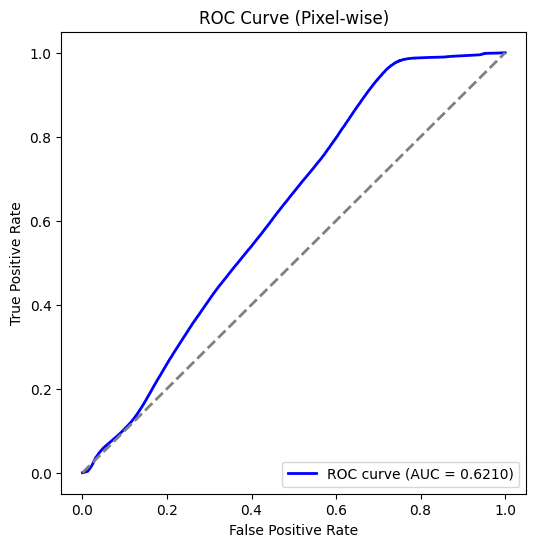

FileNotFoundError: [Errno 2] No such file or directory: 'results/roc_curve.png'

<Figure size 640x480 with 0 Axes>

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_roc_auc(model, img_paths, mask_paths, n_samples=50):
    """
    Computes ROC curve and AUC for pixel-wise classification.
    """
    y_true_all, y_pred_all = [], []

    for i in range(min(n_samples, len(img_paths))):
        img = read_image(img_paths[i])
        mask = read_mask(mask_paths[i])

        # Model prediction probabilities
        pred = model.predict(np.expand_dims(img, 0))[0][:,:,0].flatten()
        mask_bin = mask[:,:,0].astype("int").flatten()

        y_true_all.extend(mask_bin)
        y_pred_all.extend(pred)  # keep probabilities, not thresholded

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true_all, y_pred_all)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], color="gray", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Pixel-wise)")
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig(os.path.join(RESULTS_DIR, "roc_curve.png"))
    plt.close()
    print("📊 Saved ROC curve → results/roc_curve.png")

    return roc_auc

# Run ROC evaluation
roc_auc = evaluate_roc_auc(model, test_imgs, test_masks)
print(f"📈 AUC score (pixel-wise): {roc_auc:.4f}")


In [17]:
import os

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✅ Results will be saved to: {RESULTS_DIR}/")

✅ Results will be saved to: results/


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint("unet_best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
earlystop  = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reducelr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7)

callbacks = [checkpoint, earlystop, reducelr]

# Training
EPOCHS = 1
STEPS_PER_EPOCH = max(1, len(train_imgs) // BATCH_SIZE)
VAL_STEPS = max(1, len(val_imgs) // BATCH_SIZE)

history = model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7419 - dice: 0.7198 - iou: 0.5641 - loss: 0.9015 - precision: 0.9671 - recall: 0.7422 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2127s 21s/step - accuracy: 0.7429 - dice: 0.7202 - iou: 0.5645 - loss: 0.9003 - precision: 0.9672 - recall: 0.7433 - val_accuracy: 0.9594 - val_dice: 0.7821 - val_iou: 0.6423 - val_loss: 0.6588 - val_precision: 0.9604 - val_recall: 0.9989 - learning_rate: 1.0000e-04


In [21]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix (Pixel-wise)")
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"))
plt.close()
print("📊 Saved confusion matrix → results/confusion_matrix.png")

📊 Saved confusion matrix → results/confusion_matrix.png


In [ ]:
def save_predictions(img_paths, mask_paths, model, n=5):
    for i in range(n):
        img = read_image(img_paths[i])
        mask = read_mask(mask_paths[i])
        pred = model.predict(np.expand_dims(img, 0))[0]
        pred_bin = (pred[:,:,0] > 0.5).astype("float32")

        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(img); axs[0].set_title("Input Image"); axs[0].axis("off")
        axs[1].imshow(mask[:,:,0], cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
        axs[2].imshow(img); axs[2].imshow(pred_bin, cmap="jet", alpha=0.5); axs[2].set_title("Prediction"); axs[2].axis("off")

        plt.savefig(os.path.join(RESULTS_DIR, f"prediction_{i+1}.png"))
        plt.close()
    print(f"📊 Saved {n} prediction visualizations → results/prediction_*.png")

save_predictions(test_imgs, test_masks, model, n=5)